In [1]:
%pylab inline
import matplotlib.pyplot as plt
import pandas as pd
import os
import talib

Populating the interactive namespace from numpy and matplotlib


In [2]:
PATH_TO_DATA = os.getcwd()
PATH_TO_DATA = PATH_TO_DATA[:-PATH_TO_DATA[::-1].find("/")]
PATH_TO_DATA += "data/shares/"

df_emr = pd.read_csv(PATH_TO_DATA + "EMR.csv", sep=',')
df_jbl = pd.read_csv(PATH_TO_DATA + "JBL.csv", sep=',')
df_met = pd.read_csv(PATH_TO_DATA + "MET.csv", sep=',')
df_see = pd.read_csv(PATH_TO_DATA + "SEE.csv", sep=',')
df_intc = pd.read_csv(PATH_TO_DATA + "INTC.csv", sep=',')
df_nvda = pd.read_csv(PATH_TO_DATA + "NVDA.csv", sep=',')

In [3]:
def crop(df, start='2016-03-01 10:00:00', end='2016-09-01 10:00:00'):
    return df[df[df.dt == start].index[0]:df[df.dt == end].index[0]]

In [4]:
df_emr = crop(df_emr)
df_jbl = crop(df_jbl)
df_met = crop(df_met)
df_see = crop(df_see)
df_intc = crop(df_intc)
df_nvda = crop(df_nvda)

<Figure size 1152x576 with 0 Axes>

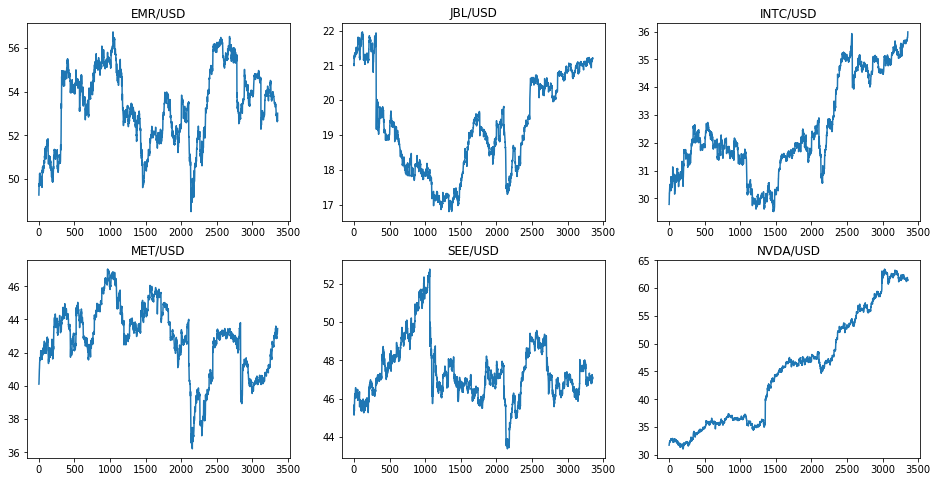

In [5]:
plt.figure(figsize(16,8))
fig, axs = plt.subplots(2, 3)

x = range(df_emr.shape[0])
axs[0,0].plot(x, df_emr['open'].values)
axs[0,1].plot(x, df_jbl['open'].values)
axs[1,0].plot(x, df_met['open'].values)
axs[1,1].plot(x, df_see['open'].values)
axs[0,2].plot(x, df_intc['open'].values)
axs[1,2].plot(x, df_nvda['open'].values)

axs[0,0].title.set_text('EMR/USD')
axs[0,1].title.set_text('JBL/USD')
axs[1,0].title.set_text('MET/USD')
axs[1,1].title.set_text('SEE/USD')
axs[0,2].title.set_text('INTC/USD')
axs[1,2].title.set_text('NVDA/USD')

plt.show()

In [6]:
class IndicatorMarks():
    
    def __init__(self):
        pass
        
    def macd_marks(self, MACD):
        periods = len(MACD)
        temp = ['hold'] * periods
        for i in range(1, periods):
            if (MACD[i] > 0 and MACD[i-1] < 0):
                temp[i] = 'buy'
            elif (MACD[i] < 0 and MACD[i-1] > 0):
                temp[i] = 'sell'
        return temp
    
    def rsi_marks(self, rsi, buy_threshold=30, sell_threshold=70):
        periods = len(rsi)
        temp = ['hold'] * periods
        for i in range(1, periods):
            if (rsi[i] < buy_threshold):
                temp[i] = 'buy'
            elif (rsi[i] > sell_threshold):
                temp[i] = 'sell'
        return temp

In [9]:
class SingleInstrumentBacktest:
    
    df = None
    price = None
    periods = None
    balance = None
    fee = None
    hold = 0
    i = 0 #current period index
    
    
    def __init__(self, df, initial_balance=100, fee=0.1):
        self.df = df
        self.price = self.df['open'].values
        self.periods = df.shape[0]
        self.df.index = pd.RangeIndex(self.periods) #refresh index
        self.balance = np.zeros(self.periods)
        self.balance[0] = initial_balance
        self.fee = fee
        
        
    def add_indicator_marks(self):
        im = IndicatorMarks()
        self.df['macd'] = talib.EMA(self.price, timeperiod=13) - talib.EMA(self.price, timeperiod=26)
        self.df['macd_mark'] = im.macd_marks(self.df['macd'].values)
        self.df['rsi_14'] = talib.RSI(self.price, timeperiod=14)
        self.df['rsi_14_mark'] = im.rsi_marks(self.df['rsi_14'].values, 30, 70)
    
    
    def buy_condition(self):
        if (self.df['rsi_14_mark'][self.i] == 'buy'):
            return True
        return False
    
    
    def sell_condition(self):
        if (self.df['rsi_14_mark'][self.i] == 'sell'):
            return True
        return False
    
    
    def step(self):
        if self.hold == 0:
            if (self.buy_condition() == True):
                self.hold = self.balance[self.i-1] / self.price[self.i] * (1.0 - self.fee/100.0)
            self.balance[self.i] = self.balance[self.i-1]
        else:
            self.balance[self.i] = self.hold * self.price[self.i] * (1.0 - self.fee/100.0)
            if (self.sell_condition() == True):
                self.hold = 0
        
        
    def full_backtest(self, show=True):
        for _ in range(1, self.periods):
            self.i += 1
            self.step()

        if show == True:
            self.show_results()
            
        return self.balance
    
    
    def show_results(self):
        plt.plot(range(self.periods), self.balance)

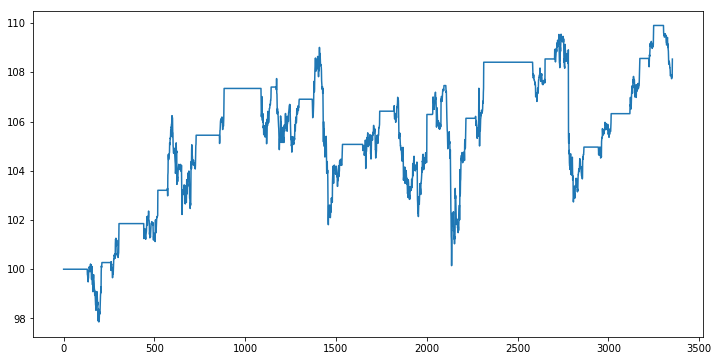

In [8]:
plt.figure(figsize(12,6))
test = SingleInstrumentBacktest(df_emr)
test.add_indicator_marks()
test.full_backtest()